In [1]:
import numpy as np
import pandas as pd
import math

from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree #модели деревьев решения
from sklearn import ensemble # ансамбль
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-v0_8')

In [2]:
churn_data = pd.read_csv('./data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

---

Далее идут операции произведеные ранее в практике по модели логистической регрессии

In [4]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [5]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

In [7]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [8]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

In [9]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0) # разделение со стратификацией

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


---

Моделирование

Дерево решений

In [17]:
decision_tree = tree.DecisionTreeClassifier(
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)
decision_tree.fit(X_train, y_train)

y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

print(metrics.f1_score(y_train, y_train_pred).round(2))
print(metrics.f1_score(y_test, y_test_pred).round(2))

0.72
0.64


Случайный лес

In [18]:
random_forest = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)

random_forest.fit(X_train, y_train)

y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

print(metrics.f1_score(y_train, y_train_pred).round(2))
print(metrics.f1_score(y_test, y_test_pred).round(2))

0.74
0.66


In [22]:
y_test_proba_pred = random_forest.predict_proba(X_test)[:,1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
y_test_proba_pred.head()

0    0.235940
1    0.394592
2    0.042540
3    0.172230
4    0.284954
dtype: float64

In [32]:
thresholds = np.arange(0.1, 1, 0.05)
f1_scores = []

for i in thresholds:
    y_test_proba = y_test_proba_pred.apply(lambda x: 1 if x> i else 0)
    f1_scores.append(metrics.f1_score(y_test, y_test_proba))

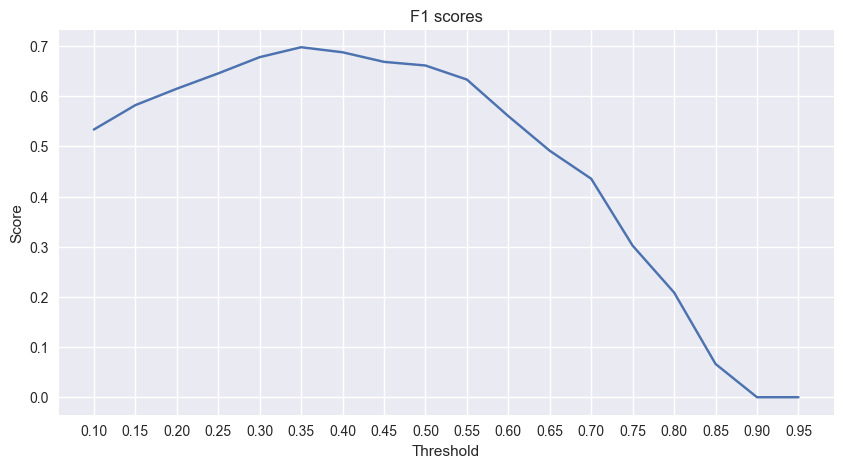

In [33]:
fig, axes = plt.subplots(figsize=(10,5))

axes.plot(thresholds, f1_scores, label='F1')
axes.set_title('F1 scores')
axes.set_xlabel('Threshold')
axes.set_xticks(thresholds)
axes.set_ylabel('Score');

In [34]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.35
#Клиентов, для которых вероятность ухода > 0.35, относим к классу 1
#В противном случае — к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_opt)))

Test F1: 0.70
